# Linear Regression from Scratch in PyTorch


Linear Regression is a foundational tool in the field of machine learning and statistics, used for predicting a continuous target variable based on one or more predictor variables. This guide delves into implementing linear regression in PyTorch, a leading deep learning library.

## Theoretical Background

Linear regression models the relationship between a dependent variable, `y`, and one or more independent variables, `X`, as a linear function:

$ y = Xw + b + \epsilon $

- $X$ represents the independent variables (features).
- $w$ is a weight matrix corresponding to the coefficients of the features.
- $b$ is the bias term, an intercept in the linear equation.
- $\epsilon$ is the error term, capturing the deviation of the predictions from the actual values.

The goal of linear regression is to find the optimal $w$ and $b$ that minimize the difference between predicted and actual values, typically using the Mean Squared Error (MSE) loss function:

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

Here, $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value for the ith instance.

## Setup

In [471]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

### Synthetic Data Generation

We generate synthetic data to mimic a real-world linear relationship, adding Gaussian noise to simulate real-world data imperfections. This data serves as a playground to test our regression models.

In [472]:
n = 1000
w = torch.tensor([2, -3.4]).reshape((-1, 1))
b = 4

X = torch.randn(n, len(w))
noise = torch.normal(mean=0, std=0.01, size=(n, 1))
y = X @ w + b + noise

c:\Users\woute\miniconda3\envs\d2l\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


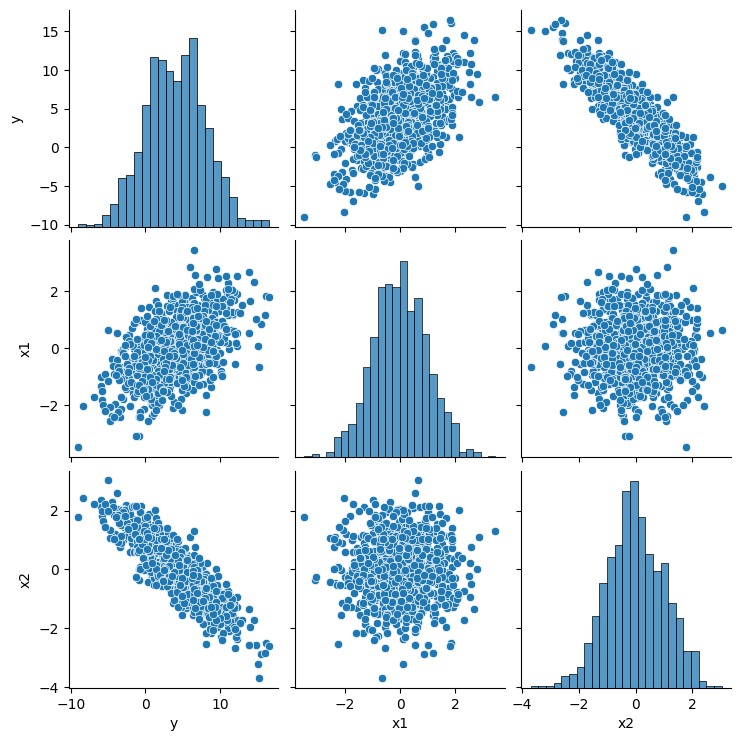

In [475]:
df = pd.DataFrame(
    torch.cat([y.reshape(-1, 1), X], dim=1),
    columns=["y", "x1", "x2"]
)
sns.pairplot(df)

### Data Splitting

The data is split into training and validation sets. The training set is used to train the model, and the validation set is used to evaluate its performance. This split helps in detecting overfitting and underfitting.

In [473]:
def train_test_split(X, y, train_size=0.8):
    # Decide the split ratio
    train_ratio = 0.8

    # Shuffle the indices
    indices = torch.randperm(len(X)).tolist()

    # Calculate the number of samples in the training set
    train_size = int(train_ratio * len(X))

    # Split the indices for train and val
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # Slice the tensors to create training and validation sets
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    
    return X_train, y_train, X_val, y_val

In [474]:
X_train, y_train, X_val, y_val = train_test_split(X, y, train_size=0.8)

## Gradient Descent From Scratch

Gradient Descent is a pivotal optimization algorithm in machine learning. It iteratively adjusts parameters ($w$ and $b$) to minimize the loss function. In each iteration, parameters are updated in the direction that most reduces the loss. In the training loop, we perform the following steps for each epoch:

1. **Forward Pass on Training Data**: Calculate predictions and compute the loss.
2. **Backward Pass**: Compute gradients of the loss with respect to model parameters.
3. **Parameter Update**: Update weights and biases using gradient descent.

After each training epoch, we evaluate the model on the validation set. This step is crucial for monitoring the model's performance on unseen data.

In [463]:
class BaseRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

    def fit(self, X_train, y_train, X_val, y_val, num_epochs, learning_rate):

        train_losses, val_losses = [], []
        for epoch in range(num_epochs):
            
            # Forward pass (training)
            y_pred_train = self.forward(X_train)
            loss_train = self.loss(y_pred_train, y_train)

            # Zero gradients (if they exist)
            if self.w.grad is not None:
                self.w.grad.zero_()
            if self.b.grad is not None:
                self.b.grad.zero_()

            # Backward pass (compute gradients)
            loss_train.backward()

            # Update parameters (gradient descent)
            with torch.no_grad():
                self.w -= learning_rate * self.w.grad
                self.b -= learning_rate * self.b.grad

            # Forward pass (validation)
            with torch.no_grad():
                y_pred_val = self.forward(X_val)
                loss_val = self.loss(y_pred_val, y_val)

            # Store losses
            train_losses.append(loss_train.item())
            val_losses.append(loss_val.item())

            # Print loss every few epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss_train.item()}, Validation Loss: {loss_val.item()}")

        # Plot the training and validation losses
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

## Linear Regression Model From Scratch

`LinearRegressionModel` extends `BaseRegressionModel`. It defines the `forward` method for  prediction and the `loss` method for calculating MSE.

In [464]:
class LinearRegressionModel(BaseRegressionModel):
    def __init__(self, in_features):
        super().__init__()
        self.w = torch.randn(in_features, 1, requires_grad=True)
        self.b = torch.zeros(1, 1, requires_grad=True)

    def forward(self, X):
        y_pred = X @ self.w + self.b
        return y_pred
    
    def loss(self, y_pred, y_true):
        loss = torch.mean((y_true - y_pred) ** 2)
        return loss


## Training the Model

Epoch 1/15, Training Loss: 39.350990295410156, Validation Loss: 24.105876922607422
Epoch 11/15, Training Loss: 0.2972433567047119, Validation Loss: 0.18186569213867188


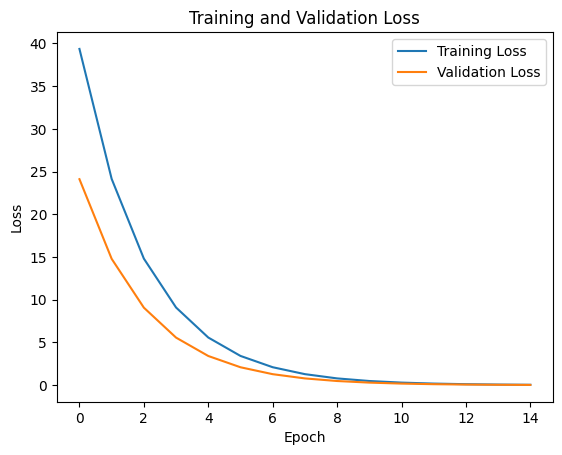

tensor([[ 1.9623],
        [-3.2907]], requires_grad=True)

In [469]:
num_epochs = 15
learning_rate = 0.1

model = LinearRegressionModel(in_features=X.shape[1])
model.fit(X_train, y_train, X_val, y_val, num_epochs, learning_rate)

model.w

## Regularized Linear Regression From Scratch

Regularization is a technique to reduce overfitting. In `RegularizedLinearRegressionModel`, we add a regularization term to the loss function:

$ \text{Total Loss} = \text{MSE Loss} + \frac{\lambda}{2} \sum_{i=1}^{d} w_i^2 $

- $\lambda$ is the regularization strength.
- The regularization term penalizes large weights, encouraging simpler models.

In [439]:
n, d = 20, 200
X = torch.randn(n, d)
noise = torch.randn(n, 1) * 0.01
w, b = torch.ones((d, 1)) * 0.01, 0.05
y = torch.matmul(X, w) + b + noise

In [440]:
X_train, y_train, X_val, y_val = train_test_split(X, y, train_size=0.2)

In [441]:
class RegularizedLinearRegressionModel(BaseRegressionModel):
    def __init__(self, in_features, lam):
        super().__init__()
        self.w = torch.normal(0, 0.01, (in_features, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        self.lam = lam

    def forward(self, X):
        y_pred = X @ self.w + self.b
        return y_pred
    
    def loss(self, y_pred, y_true):
        mse_loss = torch.mean((y_true - y_pred) ** 2)
        reg_loss = self.lam * (self.w ** 2).sum() / 2
        total_loss = mse_loss + reg_loss
        return total_loss

We compare the performance of the regularized model with different $\lambda$ values to illustrate the effect of regularization.

Epoch 1/100, Training Loss: 0.04684655740857124, Validation Loss: 0.10158438980579376
Epoch 11/100, Training Loss: 0.026922419667243958, Validation Loss: 0.09715048223733902
Epoch 21/100, Training Loss: 0.015787644311785698, Validation Loss: 0.09375359117984772
Epoch 31/100, Training Loss: 0.009442377835512161, Validation Loss: 0.09109468013048172
Epoch 41/100, Training Loss: 0.005754092708230019, Validation Loss: 0.08898269385099411
Epoch 51/100, Training Loss: 0.0035678313579410315, Validation Loss: 0.08728814125061035
Epoch 61/100, Training Loss: 0.0022472937125712633, Validation Loss: 0.08591892570257187
Epoch 71/100, Training Loss: 0.0014354779850691557, Validation Loss: 0.0848069041967392
Epoch 81/100, Training Loss: 0.0009282812243327498, Validation Loss: 0.08390026539564133
Epoch 91/100, Training Loss: 0.0006067657959647477, Validation Loss: 0.08315878361463547


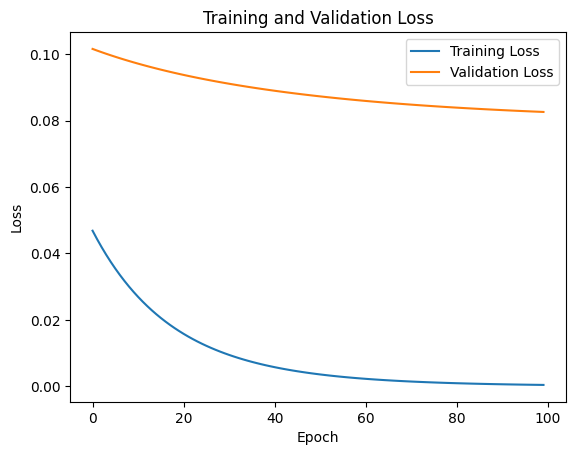

In [442]:
num_epochs = 100
learning_rate = 0.001
lam = 0

model = RegularizedLinearRegressionModel(in_features=X.shape[1], lam=lam)
model.fit(X_train, y_train, X_val, y_val, num_epochs, learning_rate)

Epoch 1/100, Training Loss: 0.13359278440475464, Validation Loss: 0.10713636130094528
Epoch 11/100, Training Loss: 0.09432200342416763, Validation Loss: 0.0880347341299057
Epoch 21/100, Training Loss: 0.07085271924734116, Validation Loss: 0.07471877336502075
Epoch 31/100, Training Loss: 0.05555935949087143, Validation Loss: 0.06488444656133652
Epoch 41/100, Training Loss: 0.04484095424413681, Validation Loss: 0.057364460080862045
Epoch 51/100, Training Loss: 0.036908891052007675, Validation Loss: 0.051505982875823975
Epoch 61/100, Training Loss: 0.030816109851002693, Validation Loss: 0.04690273106098175
Epoch 71/100, Training Loss: 0.026021938771009445, Validation Loss: 0.04327663034200668
Epoch 81/100, Training Loss: 0.022192012518644333, Validation Loss: 0.04042348265647888
Epoch 91/100, Training Loss: 0.01910344697535038, Validation Loss: 0.03818640857934952


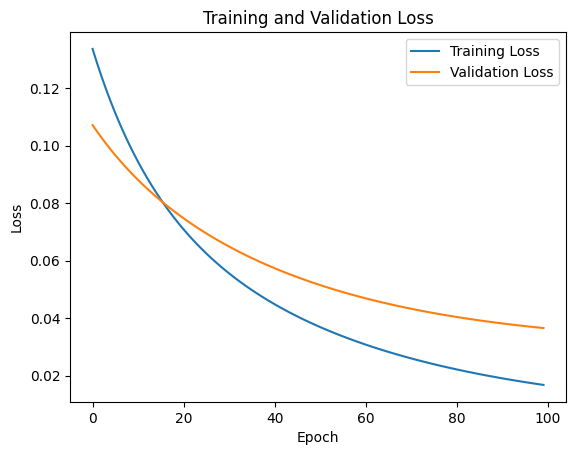

In [443]:
num_epochs = 100
learning_rate = 0.001
lam = 10

model = RegularizedLinearRegressionModel(in_features=X.shape[1], lam=lam)
model.fit(X_train, y_train, X_val, y_val, num_epochs, learning_rate)

## Concise Implementation of Linear Regression with SGD

For a more concise implementation, we leverage PyTorch's built-in modules:

- **`nn.Linear`**: Defines a linear layer with weights and biases.
- **`optim.SGD`**: Stochastic Gradient Descent optimizer.
- **`nn.MSELoss`**: Mean Squared Error loss function.

These functions abstract away much of the manual work, allowing for a more streamlined and error-free implementation.

In [444]:
n = 1000
w = torch.tensor([2, -3.4]).reshape((-1, 1))
b = 4

X = torch.randn(n, len(w))
noise = torch.normal(mean=0, std=0.01, size=(n, 1))
y = X @ w + b + noise

In [445]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

model = LinearRegression(X.shape[1])

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the Model
for epoch in range(100):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [446]:
model.linear.weight

Parameter containing:
tensor([[ 1.9999, -3.3997]], requires_grad=True)